Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

Problem: Navier-Stokes Equation with energy equation

        u*u_x + v*u_y - sqrt(Pr/Ra)*(u_xx+u_yy) + p_x = 0
        v*v_x + v*v_y - sqrt(Pr/Ra)*(v_xx+v_yy) + p_y + T = 0
        u*T_x + v*T_y - 1/sqrt(Pr*Ra)*(T_xx + T_yy) = 0  
        u_x + v_y = 0

Note: inital condition is steady-state solution @ Ra = 2e3

DNN / PINN   

In [2]:
class PINN(nn.Module):
    global nn_acf
    nn_acf = nn.silu
    
    """PINNs"""
    n_nodes: int    
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]     
        self.splitT = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerT = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]  
        
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x, y = inputs[:,0:1], inputs[:,1:2], inputs[:,2:3]
        def get_uvp(t, x, y):
            inputs = jnp.hstack([t /50., (x - 1.) /4., (x - 2.) /4., (x - 3.) /4., y, y - 1.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(4*jnp.pi*hidden)
            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            T = self.splitT(hidden)
            for i, lyr in enumerate(self.layerT):
                T = lyr(T)                
            return (u, v, p, T)
    
        u, v, p, T = get_uvp(t, x, y)

        def get_uvp_xy(get_uvp, t, x, y):
            u_t, v_t, p_t, T_t = jacfwd(get_uvp)(t, x, y)
            u_x, v_x, p_x, T_x = jacfwd(get_uvp, argnums=1)(t, x, y)
            u_y, v_y, p_y, T_y = jacfwd(get_uvp, argnums=2)(t, x, y)
            return u_t, u_x, u_y, v_t, v_x, v_y, p_t, p_x , p_y, T_t, T_x, T_y
            
        get_uvp_xy_vmap = vmap(get_uvp_xy, in_axes=(None, 0, 0, 0))
        u_t, u_x, u_y, v_t, v_x, v_y, _, p_x, p_y, T_t, T_x, T_y = get_uvp_xy_vmap(get_uvp, t, x, y)
        u_t, u_x, u_y, v_t, v_x, v_y = u_t[:,:,0], u_x[:,:,0], u_y[:,:,0], v_t[:,:,0], v_x[:,:,0], v_y[:,:,0]
        p_x, p_y, T_t, T_x, T_y = p_x[:,:,0], p_y[:,:,0], T_t[:,:,0], T_x[:,:,0], T_y[:,:,0]

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, t, x, y):
            u_xx, v_xx, p_xx, T_xx = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(t, x, y)
            u_yy, v_yy, p_yy, T_yy = jacfwd(jacfwd(get_uvp, argnums=2), argnums=2)(t, x, y)
            return u_xx, u_yy, v_xx, v_yy, p_xx, p_yy, T_xx, T_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0, 0))
        u_xx, u_yy, v_xx, v_yy, _ , _, T_xx, T_yy = get_uvp_xxyy_vmap(get_uvp, t, x, y)
        u_xx, u_yy, v_xx, v_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0]
        T_xx, T_yy = T_xx[:,:,0,0], T_yy[:,:,0,0]

        # obtain BC indices
        #nbc = (x != x_l) | (x != x_u) | (y != y_l) | (y != y_u)
        ibc = (t == t_l)
        bc  = ( (x == x_l) | (x == x_u) | (y == y_l) | (y == y_u) ) & (t > t_l)
        nbc = (~bc) & (t > t_l)
        T_bc = ( (x == x_l) | (x == x_u) ) & (t > t_l)

        # compute PDE residual : N-S equations
        # continuity = u_x + v_y
        # momentum_1 = u*u_x + v*u_y + p_x - sqrt(Pr/Ra)*(u_xx + u_yy)
        # momentum_2 = u*v_x + v*v_y + p_y - sqrt(Pr/Ra)*(v_xx + v_yy)
        # energy     = u*T_x + v*T_y       - 1/sqrt(Pr*Ra)*(T_xx + T_yy)
        residuals_continuity = u_x + v_y
        residuals_momentum_1 = u_t + u*u_x + v*u_y + p_x - jnp.sqrt(Pr/Ra)*(u_xx + u_yy)
        residuals_momentum_2 = v_t + u*v_x + v*v_y + p_y - jnp.sqrt(Pr/Ra)*(v_xx + v_yy) - T
        residuals_energy     = T_t + u*T_x + v*T_y - 1.0/jnp.sqrt(Pr*Ra)*(T_xx + T_yy)
        mom1 = - jnp.sqrt(Pr/Ra)*(u_xx + u_yy)
        mom2 = - jnp.sqrt(Pr/Ra)*(v_xx + v_yy)
        mom3 = - 1.0/jnp.sqrt(Pr*Ra)*(T_xx + T_yy)
        
        outputs = jnp.hstack([u, v, p, T, residuals_continuity, residuals_momentum_1, residuals_momentum_2, residuals_energy, T_x, ibc, bc, T_bc, nbc, mom1, mom2, mom3])
        return outputs 


class DNN(nn.Module):
    global nn_acf
    nn_acf = nn.silu    
    """DNNs"""
    n_nodes: int
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]     
        self.splitT = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerT = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]  
        
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x, y = inputs[:,0:1], inputs[:,1:2], inputs[:,2:3]
        def get_uvp(t, x, y):
            inputs = jnp.hstack([t /50., (x - 1.) /4., (x - 2.) /4., (x - 3.) /4., y, y - 1.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(4*jnp.pi*hidden)
            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            T = self.splitT(hidden)
            for i, lyr in enumerate(self.layerT):
                T = lyr(T)                
            return (u, v, p, T)
    
        u, v, p, T = get_uvp(t, x, y)

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, t, x, y):
            u_xx, v_xx, p_xx, T_xx = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(t, x, y)
            u_yy, v_yy, p_yy, T_yy = jacfwd(jacfwd(get_uvp, argnums=2), argnums=2)(t, x, y)
            return u_xx, u_yy, v_xx, v_yy, p_xx, p_yy, T_xx, T_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0, 0))
        u_xx, u_yy, v_xx, v_yy, _ , _, T_xx, T_yy = get_uvp_xxyy_vmap(get_uvp, t, x, y)
        u_xx, u_yy, v_xx, v_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0]
        T_xx, T_yy = T_xx[:,:,0,0], T_yy[:,:,0,0]

        mom1 = - jnp.sqrt(Pr/Ra)*(u_xx + u_yy)
        mom2 = - jnp.sqrt(Pr/Ra)*(v_xx + v_yy)
        mom3 = - 1.0/jnp.sqrt(Pr*Ra)*(T_xx + T_yy)

        #shift p_ref
        x_pref, y_pref = jnp.ones_like(x)*x_ref, jnp.ones_like(y)*y_ref
        _, _, pref, _ = get_uvp(t, x_pref, y_pref)
        pout = p - pref
        
        outputs = jnp.hstack([u, v, pout, T, mom1, mom2, mom3])
        return outputs 

In [3]:
def main(ER, ER_xx, weight_ic, weight_bc, max_lr, exponent, max_iter, seed, gpu):

    global Ra, Pr, t_l, t_u, x_l, x_u, y_l, y_u, x_ref, y_ref
    
    # parameter
    Pr = 0.71
    Ra = 1e5
        
    # parameter
    Pr = 0.71
    Ra = 1e5
        
    all_files = glob.glob(os.path.join('rb_data' , "*.dat"))
    all_files.sort()
    dt_count = len(all_files) - 1
    
    sim = pd.concat((pd.read_csv(f,sep='\\s+') for f in all_files), ignore_index=True)
    # spatial-temporal domain
    sim_t, sim_x, sim_y = sim['t'].values.reshape(-1,1), sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1)
    sim_u, sim_v, sim_p, sim_T = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1), sim['T'].values.reshape(-1,1)   
    t_l, t_u, x_l, x_u, y_l, y_u = np.min(sim_t), np.max(sim_t), np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)
    #ext = [x_l, x_u, y_l, y_u]
    #print (t_l, t_u, x_l, x_u, y_l, y_u)

    data_X, data_Y = np.hstack([sim_t, sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p, sim_T])

    _bc = ( (data_X[:,1] == x_l) | (data_X[:,1] == x_u) | (data_X[:,2] == y_l) | (data_X[:,2] == y_u) ) & (data_X[:,0] > t_l)
    data_X_BC, data_Y_BC = data_X[_bc], data_Y[_bc]
    _ic = (data_X[:,0] == t_l)
    data_X_IC, data_Y_IC = data_X[_ic], data_Y[_ic]
    # convert to jnp
    data_X, data_Y= jnp.array(data_X), jnp.array(data_Y)
    data_X_BC, data_Y_BC = jnp.array(data_X_BC), jnp.array(data_Y_BC)
    data_X_IC, data_Y_IC = jnp.array(data_X_IC), jnp.array(data_Y_IC)
    
    # pressure ref
    x_ref, y_ref = np.unique(sim.x), np.unique(sim.y)
    x_ref, y_ref = np.take(x_ref, x_ref.size //2), np.take(y_ref, y_ref.size //2)

    BS_ALL = 4000
    BS_BC = 100
    BS_IC = 50
    BS_PDE = BS_ALL - BS_BC - BS_IC
    
    n_all, n_BC, n_IC = len(data_X), len(data_X_BC), len(data_X_IC)
    print('The total number of samples:')
    print('n_all=', n_all, ' n_BC=', n_BC, ' n_IC=', n_IC)

    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))
    
    # dummy input
    a = random.normal(key, [1,3])
    
    # initialization call
    n_nodes = 64
    model, model_0 = PINN(n_nodes), DNN(n_nodes)
    params = model.init(key, a) 
    num_params, format_params_fn = get_params_format_fn(params)
    #print (num_params)
    
    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]  
    params_0 = params 

    @jit
    def minibatch(key):
        key1, key2, key3 = key
        batch_all = random.choice(key1, n_all , (BS_PDE,))
        batch_bc = random.choice(key2, n_BC, (BS_BC,))   
        batch_ic = random.choice(key3, n_IC, (BS_IC,))          
        batch_X = jnp.vstack([data_X[batch_all], 
                              data_X_BC[batch_bc], 
                              data_X_IC[batch_ic]])
        batch_Y = jnp.vstack([data_Y[batch_all], 
                              data_Y_BC[batch_bc],
                              data_Y_IC[batch_ic]])
        return (batch_X, batch_Y)

    def eval_loss(params,params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, v, p, T, residuals_continuity, residuals_momentum_1, residuals_momentum_2, residuals_energy, T_x, ibc, bc, T_bc, nbc, m_1, m_2, m_3 = jnp.split(pred, 16, axis=1)
        gt_u, gt_v, gt_p, gt_T = jnp.split(labels, 4, axis=1)
        # stable evolution
        pred0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, v_0, p_0, T_0, m0_1, m0_2, m0_3 = jnp.split(pred0, 7, axis=1) 
        # PDE
        residuals_continuity = residuals_continuity + (p - p_0) / ER # ER @PDE
        residuals_momentum_1 = residuals_momentum_1 + (u - u_0) / ER + (m_1 - m0_1) / ER_xx # ER @PDE
        residuals_momentum_2 = residuals_momentum_2 + (v - v_0) / ER + (m_2 - m0_2) / ER_xx # ER @PDE
        residuals_energy     = residuals_energy     + (T - T_0) / ER + (m_3 - m0_3) / ER_xx # ER @PDE
        pde_uvp  = jnp.square(residuals_continuity) + jnp.square(residuals_momentum_1) + jnp.square(residuals_momentum_2) + jnp.square(residuals_energy)
        pde_loss = jnp.sum(pde_uvp*nbc) / nbc.sum()
        # IC loss
        ic_u, ic_v, ic_p, ic_T = (u - gt_u), (v - gt_v), (p - gt_p), (T - gt_T)
        ic_uv   = jnp.square(ic_u) + jnp.square(ic_v) + jnp.square(ic_p) + jnp.square(ic_T)
        ic_loss = jnp.sum(ic_uv*ibc) / ibc.sum()
        # BC loss
        bc_u, bc_v, bc_T = ic_u, ic_v, ic_T
        bc_T    = jnp.where(T_bc, T_x, bc_T)
        bc_uv   = jnp.square(bc_u) + jnp.square(bc_v) + jnp.square(bc_T)
        bc_loss = jnp.sum(bc_uv*bc) / bc.sum()
 
        loss = pde_loss + bc_loss*weight_bc + ic_loss*weight_ic

        mse_u = jnp.mean(jnp.square(u - gt_u)) 
        mse_v = jnp.mean(jnp.square(v - gt_v)) 
        mse_T = jnp.mean(jnp.square(T - gt_T)) 
        l2_u = jnp.linalg.norm(u - gt_u) / jnp.linalg.norm(gt_u)
        l2_v = jnp.linalg.norm(v - gt_v) / jnp.linalg.norm(gt_v)
        l2_T = jnp.linalg.norm(T - gt_T) / jnp.linalg.norm(gt_T)
     
        return loss, (mse_u, mse_v, mse_T, l2_u, l2_v, l2_T, pde_loss, bc_loss, ic_loss)
    
    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))    

    # weights update  
    @jit
    def update(params, params_0, opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse_u, mse_v, mse_T, l2_u, l2_v, l2_T, pde_loss, bc_loss, ic_loss)), grad = loss_grad(params,params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss, mse_u, mse_v, mse_T, l2_u, l2_v, l2_T, pde_loss, bc_loss, ic_loss
    
    # optimizer
    max_iters = max_iter
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=int(0.0*max_iters),  
                                                      decay_steps=max_iters, end_value=1e-10,exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    # training iteration
    runtime = 0
    train_iters = 0
    
    store = []
    while (train_iters <= max_iters):
        # mini-batch update
        start = time.time()
        key1, key2, key3, rng = random.split(rng, 4) # update random generator
        params, params_0, opt_state, loss, mse_u, mse_v, mse_T, l2_u, l2_v, l2_T, pde_loss, bc_loss, ic_loss = update(params,params_0, opt_state, (key1, key2, key3))
        end = time.time()
        runtime += (end-start)    
        # append weights
        if (train_iters % 10000 == 0):
            print ('iter. = %05d,  time = %03ds,  loss = %.2e | mse_u = %.2e,  mse_v = %.2e,  mse_T = %.2e'%(train_iters, runtime, loss,mse_u, mse_v, mse_T))
            store.append([train_iters, runtime, loss, mse_u, mse_v, mse_T, l2_u, l2_v, l2_T, pde_loss, bc_loss, ic_loss])    
        train_iters += 1
    
    store = jnp.array(store)

    """PINN solution"""
     
    # info. to pass down to next time window..
    params_T = format_params_fn(params)

    mse_u = mse_v = mse_p = mse_T = mse_V = l2_u = l2_v = l2_p = l2_T = l2_V = 0.0
    x_total = len(data_X)
    for i in range(0,6):
        ts, te = t_l + i*10, t_l + (i+1)*10
        #print("t = [" , ts , "~" , te , ")")
        _t = (data_X[:,0] >= t_l + i*10) & (data_X[:,0] < t_l + (i+1)*10)
    
        inputs, labels = data_X[_t], data_Y[_t]
        uvp = model_0.apply(params_T, inputs)
        u, v, p, T = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4]
        gt_u, gt_v, gt_p, gt_T = jnp.split(labels, 4, axis=-1)

        gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
        V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
        mse_T = mse_T + jnp.sum(jnp.square(T - gt_T))
        mse_V = mse_V + jnp.sum(jnp.square(V - gt_V))
        l2_T = l2_T + jnp.sum(jnp.square(gt_T))
        l2_V = l2_V + jnp.sum(jnp.square(gt_V))

    l2_T = jnp.sqrt(mse_T)/jnp.sqrt(l2_T)
    l2_V = jnp.sqrt(mse_V)/jnp.sqrt(l2_V)
    mse_T = (mse_T)/x_total
    mse_V = (mse_V)/x_total
    
    print ('[RB]: mse_T = %.2e,  mse_V = %.2e, rl2_T = %.2e,  rl2_V = %.2e'%(mse_T, mse_V, l2_T, l2_V))

    return params_T


In [4]:
params = main(ER=0.1, ER_xx=1.5, weight_ic=1, weight_bc=10,
              max_lr=5e-3, exponent=1.0, max_iter=50000, seed=10, gpu=0)

The total number of samples:
n_all= 8531028  n_BC= 322000  n_IC= 17028
iter. = 00000,  time = 016s,  loss = 7.79e+01 | mse_u = 1.91e-01,  mse_v = 1.68e-01,  mse_T = 1.22e-01
iter. = 10000,  time = 090s,  loss = 3.50e-02 | mse_u = 4.68e-04,  mse_v = 3.55e-04,  mse_T = 8.81e-04
iter. = 20000,  time = 164s,  loss = 7.34e-03 | mse_u = 2.54e-04,  mse_v = 1.82e-04,  mse_T = 4.03e-04
iter. = 30000,  time = 239s,  loss = 1.47e-03 | mse_u = 2.07e-04,  mse_v = 9.49e-05,  mse_T = 3.20e-04
iter. = 40000,  time = 313s,  loss = 3.62e-04 | mse_u = 1.71e-04,  mse_v = 7.82e-05,  mse_T = 2.59e-04
iter. = 50000,  time = 388s,  loss = 1.52e-04 | mse_u = 1.73e-04,  mse_v = 7.19e-05,  mse_T = 2.46e-04
[RB]: mse_T = 2.62e-04,  mse_V = 2.22e-04, rl2_T = 8.02e-02,  rl2_V = 5.22e-02


    [RB]: mse_T = 2.62e-04,  mse_V = 2.23e-04,  rl2_T = 8.02e-02,  rl2_V = 5.23e-02

Near field

In [39]:
all_files = glob.glob(os.path.join('rb_data' , "*.dat"))
all_files.sort()
dt_count = len(all_files) - 1
    
sim = pd.concat((pd.read_csv(f, sep='\\s+') for f in all_files), ignore_index=True)
# spatial-temporal domain
sim_t, sim_x, sim_y = sim['t'].values.reshape(-1,1), sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1)
sim_u, sim_v, sim_p, sim_T = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1), sim['T'].values.reshape(-1,1)   
t_l, t_u, x_l, x_u, y_l, y_u = np.min(sim_t), np.max(sim_t), np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)
ext = [x_l, x_u, y_l, y_u]
#print (t_l, t_u, x_l, x_u, y_l, y_u)
data_X, data_Y = np.hstack([sim_t, sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p, sim_T])
x_total = len(data_X)

# mode prediction
model = DNN(64)

u_all, v_all, p_all, T_all = [], [], [], []
mse_u = mse_v = mse_p = mse_T = mse_V = l2_u = l2_v = l2_p = l2_T = l2_V = 0.0
for i in range(0,6):
    ts, te = t_l + i*10, t_l + (i+1)*10
    _t = (data_X[:,0] >= t_l + i*10) & (data_X[:,0] < t_l + (i+1)*10)

    inputs, labels = data_X[_t], data_Y[_t]
    uvp = model.apply(params, inputs)
    u, v, p, T = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4]
    u_all.append(u)
    v_all.append(v)
    p_all.append(p)
    T_all.append(T)
    
    gt_u, gt_v, gt_p, gt_T = jnp.split(labels, 4, axis=-1)
    gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
    V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
    mse_T = mse_T + jnp.sum(jnp.square(T - gt_T))
    mse_V = mse_V + jnp.sum(jnp.square(V - gt_V))
    l2_T = l2_T + jnp.sum(jnp.square(gt_T))
    l2_V = l2_V + jnp.sum(jnp.square(gt_V))

l2_T = jnp.sqrt(mse_T)/jnp.sqrt(l2_T)
l2_V = jnp.sqrt(mse_V)/jnp.sqrt(l2_V)
mse_T = (mse_T)/x_total
mse_V = (mse_V)/x_total 
print ('[RB]: mse_T = %.2e,  mse_V = %.2e, rl2_T = %.2e,  rl2_V = %.2e'%(mse_T, mse_V, l2_T, l2_V))

[RB]: mse_T = 2.62e-04,  mse_V = 2.22e-04, rl2_T = 8.02e-02,  rl2_V = 5.22e-02


In [40]:
# merge data
u, v, p, T = u_all[0], v_all[0], p_all[0], T_all[0]
for i in range(1,len(u_all)):
    u, v, p, T = np.vstack([u, u_all[i]]), np.vstack([v, v_all[i]]), np.vstack([p, p_all[i]]), np.vstack([T, T_all[i]])

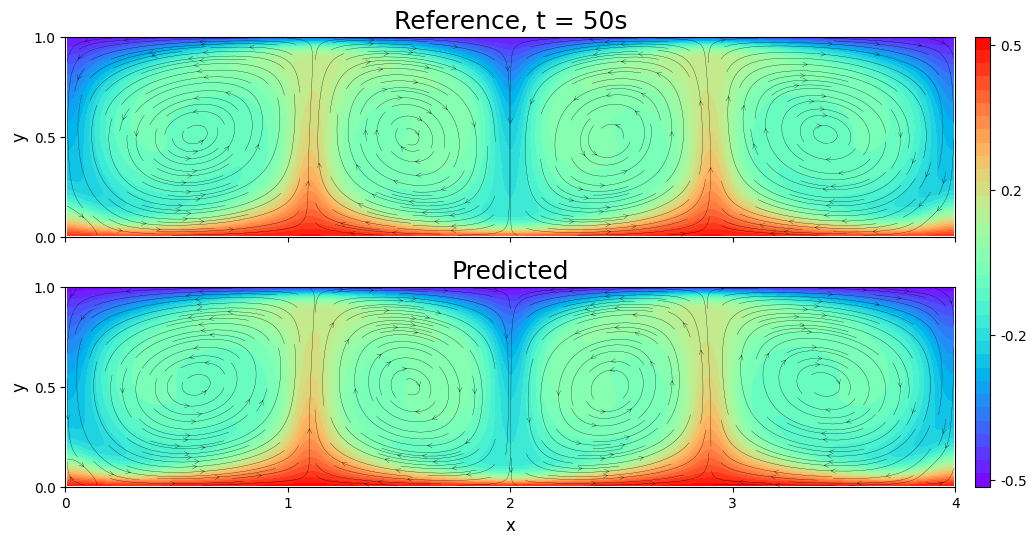

In [104]:
# plot streamline
t = 50

_t = (data_X[:,0] == t_l+t ) & ( data_X[:,1] != x_l ) & ( data_X[:,1] != x_u ) & ( data_X[:,2] != y_l )  & ( data_X[:,2] != y_u )

test_X, test_Y = data_X[_t, 1].reshape(64,256), data_X[_t, 2].reshape(64,256)
cfd_u, cfd_v, cfd_T = data_Y[_t, 0].reshape(64,256), data_Y[_t, 1].reshape(64,256), data_Y[_t, 3].reshape(64,256)
pre_u, pre_v, pre_T = u[_t].reshape(64,256), v[_t].reshape(64,256), T[_t].reshape(64,256)
titles = ['Reference, t = %ds'%t, 'Predicted']
    
cfd_V = np.sqrt(cfd_u**2 + cfd_v**2)
pre_V = np.sqrt(pre_u**2 + pre_v**2)
    
u_list = [cfd_u, pre_u]
v_list = [cfd_v, pre_v]
T_list = [cfd_T, pre_T]
V_list = [cfd_V, pre_V]
    
# template
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4.5), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=0.89, top=1, bottom=0, hspace=.25)
    
cmap = plt.cm.rainbow
test_x = np.linspace(min(test_X[0,:]), max(test_X[0,:]), 256)
test_y = np.linspace(min(test_Y[:,0]), max(test_Y[:,0]), 64)

# plot
for i in range(2):
    ax = axs[i]
    test_u, test_v, test_V, test_T = u_list[i], v_list[i], V_list[i], T_list[i]
    bg = ax.contourf(test_X, test_Y, test_T, levels=35, cmap=cmap, alpha=1,
                      zorder=0)
    ax.streamplot(test_x, test_y, test_u, test_v,
                  color='k', linewidth=.2, density=2.,
                  arrowsize=.8, arrowstyle='->', zorder=1)
    ax.set_xlim(0, 4); ax.set_ylim(0, 1);
    ax.set_xticks(np.linspace(0, 4, 5)); ax.set_yticks(np.linspace(0, 1, 3));
    ax.set_title(titles[i], fontsize=18)
    #ax.set_aspect('equal')
        
# label
axs[1].set_xlabel('x', fontsize=12)
axs[1].set_ylabel('y', fontsize=12)
axs[0].set_ylabel('y', fontsize=12)

# colorbar
vmin = min(np.min(pre_T), np.min(cfd_T))
vmax = max(np.max(pre_T), np.max(cfd_T))
tick_vals = np.linspace(vmin, vmax, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]

cbar_ax = fig.add_axes([0.91, 0., 0.015, 1.]); # [left, bottom, width, height]
cbar = fig.colorbar(bg, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=10);

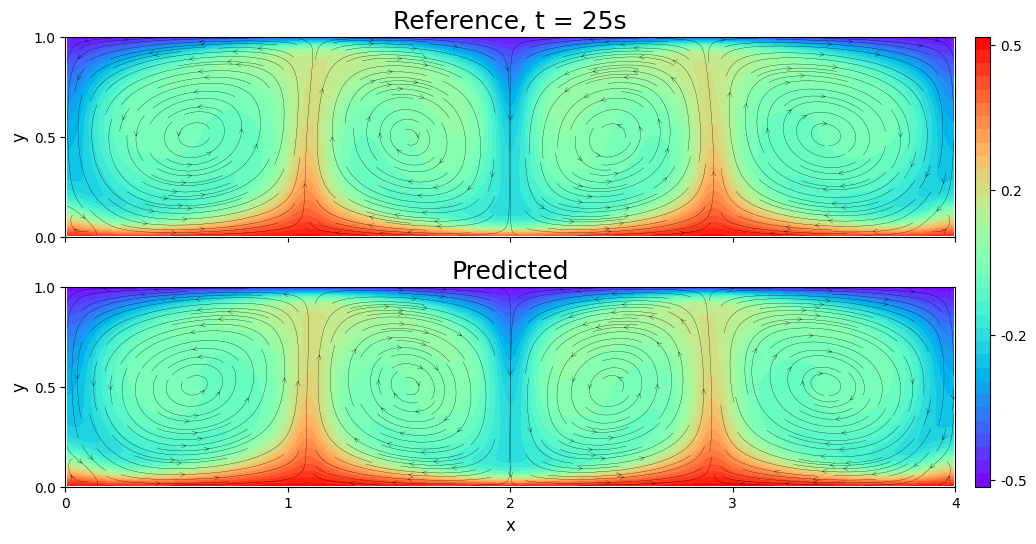

In [168]:
# plot streamline
t = 25

_t = (data_X[:,0] == t_l+t ) & ( data_X[:,1] != x_l ) & ( data_X[:,1] != x_u ) & ( data_X[:,2] != y_l )  & ( data_X[:,2] != y_u )

test_X, test_Y = data_X[_t, 1].reshape(64,256), data_X[_t, 2].reshape(64,256)
cfd_u, cfd_v, cfd_T = data_Y[_t, 0].reshape(64,256), data_Y[_t, 1].reshape(64,256), data_Y[_t, 3].reshape(64,256)
pre_u, pre_v, pre_T = u[_t].reshape(64,256), v[_t].reshape(64,256), T[_t].reshape(64,256)
titles = ['Reference, t = %ds'%t, 'Predicted']
    
cfd_V = np.sqrt(cfd_u**2 + cfd_v**2)
pre_V = np.sqrt(pre_u**2 + pre_v**2)
    
u_list = [cfd_u, pre_u]
v_list = [cfd_v, pre_v]
T_list = [cfd_T, pre_T]
V_list = [cfd_V, pre_V]
    
# template
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4.5), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=0.89, top=1, bottom=0, hspace=.25)
    
cmap = plt.cm.rainbow
test_x = np.linspace(min(test_X[0,:]), max(test_X[0,:]), 256)
test_y = np.linspace(min(test_Y[:,0]), max(test_Y[:,0]), 64)

# plot
for i in range(2):
    ax = axs[i]
    test_u, test_v, test_V, test_T = u_list[i], v_list[i], V_list[i], T_list[i]
    bg = ax.contourf(test_X, test_Y, test_T, levels=35, cmap=cmap, alpha=1,
                      zorder=0)
    ax.streamplot(test_x, test_y, test_u, test_v,
                  color='k', linewidth=.2, density=2.,
                  arrowsize=.8, arrowstyle='->', zorder=1)
    ax.set_xlim(0, 4); ax.set_ylim(0, 1);
    ax.set_xticks(np.linspace(0, 4, 5)); ax.set_yticks(np.linspace(0, 1, 3));
    ax.set_title(titles[i], fontsize=18)
    #ax.set_aspect('equal')
        
# label
axs[1].set_xlabel('x', fontsize=12)
axs[1].set_ylabel('y', fontsize=12)
axs[0].set_ylabel('y', fontsize=12)

# colorbar
vmin = min(np.min(pre_T), np.min(cfd_T))
vmax = max(np.max(pre_T), np.max(cfd_T))
tick_vals = np.linspace(vmin, vmax, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]

cbar_ax = fig.add_axes([0.91, 0., 0.015, 1.]); # [left, bottom, width, height]
cbar = fig.colorbar(bg, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=10);

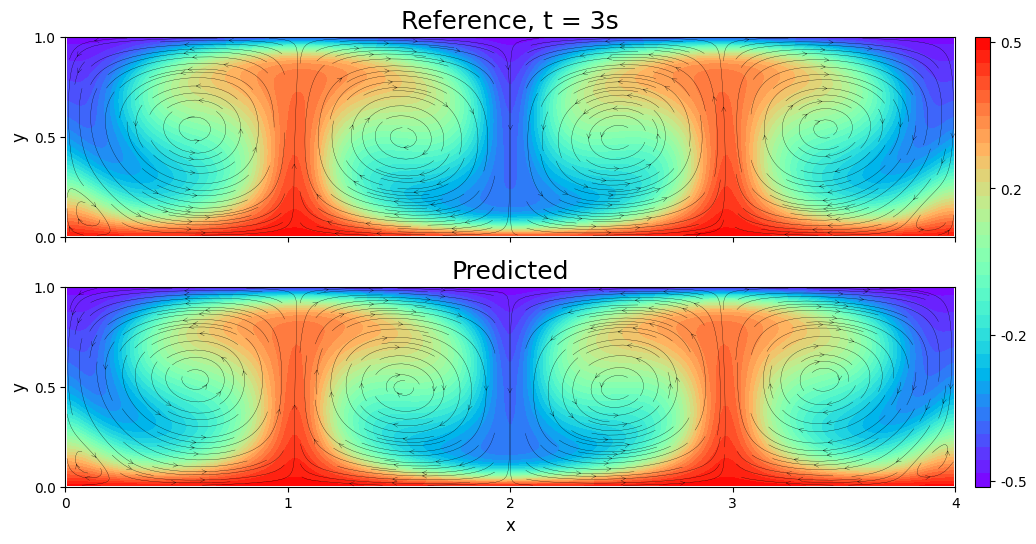

In [138]:
# plot streamline
t = 3

_t = (data_X[:,0] == t_l+t ) & ( data_X[:,1] != x_l ) & ( data_X[:,1] != x_u ) & ( data_X[:,2] != y_l )  & ( data_X[:,2] != y_u )

test_X, test_Y = data_X[_t, 1].reshape(64,256), data_X[_t, 2].reshape(64,256)
cfd_u, cfd_v, cfd_T = data_Y[_t, 0].reshape(64,256), data_Y[_t, 1].reshape(64,256), data_Y[_t, 3].reshape(64,256)
pre_u, pre_v, pre_T = u[_t].reshape(64,256), v[_t].reshape(64,256), T[_t].reshape(64,256)
titles = ['Reference, t = %ds'%t, 'Predicted']
    
cfd_V = np.sqrt(cfd_u**2 + cfd_v**2)
pre_V = np.sqrt(pre_u**2 + pre_v**2)
    
u_list = [cfd_u, pre_u]
v_list = [cfd_v, pre_v]
T_list = [cfd_T, pre_T]
V_list = [cfd_V, pre_V]
    
# template
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4.5), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=0.89, top=1, bottom=0, hspace=.25)
    
cmap = plt.cm.rainbow
test_x = np.linspace(min(test_X[0,:]), max(test_X[0,:]), 256)
test_y = np.linspace(min(test_Y[:,0]), max(test_Y[:,0]), 64)

# plot
for i in range(2):
    ax = axs[i]
    test_u, test_v, test_V, test_T = u_list[i], v_list[i], V_list[i], T_list[i]
    bg = ax.contourf(test_X, test_Y, test_T, levels=35, cmap=cmap, alpha=1,
                      zorder=0)
    ax.streamplot(test_x, test_y, test_u, test_v,
                  color='k', linewidth=.2, density=2.,
                  arrowsize=.8, arrowstyle='->', zorder=1)
    ax.set_xlim(0, 4); ax.set_ylim(0, 1);
    ax.set_xticks(np.linspace(0, 4, 5)); ax.set_yticks(np.linspace(0, 1, 3));
    ax.set_title(titles[i], fontsize=18)
    #ax.set_aspect('equal')
        
# label
axs[1].set_xlabel('x', fontsize=12)
axs[1].set_ylabel('y', fontsize=12)
axs[0].set_ylabel('y', fontsize=12)

# colorbar
vmin = min(np.min(pre_T), np.min(cfd_T))
vmax = max(np.max(pre_T), np.max(cfd_T))
tick_vals = np.linspace(vmin, vmax, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]

cbar_ax = fig.add_axes([0.91, 0., 0.015, 1.]); # [left, bottom, width, height]
cbar = fig.colorbar(bg, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=10);

Contour plot

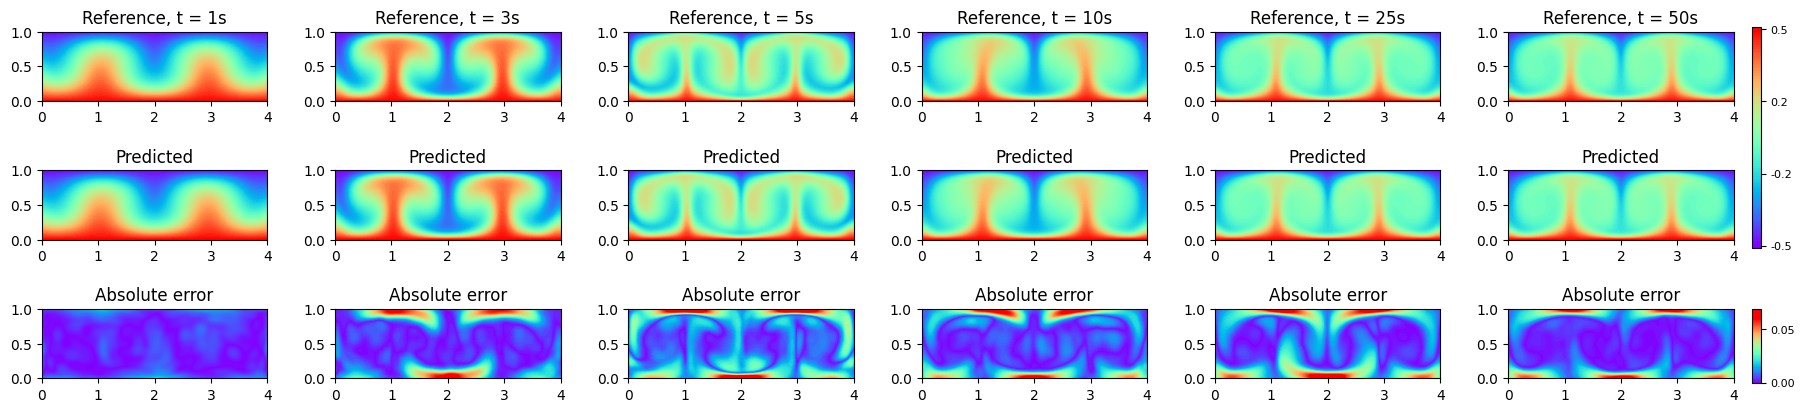

In [167]:
fig = plt.figure(figsize=(18, 4.5))
fig.subplots_adjust(left=0, right=0.94, hspace=1., wspace=.3)
con_lv = 101
i = 1
for t in [1, 3, 5, 10, 25, 50]:
    # plot T
    _t = (data_X[:,0] == t_l+t )
    cfd, pinn = data_Y[_t, 3], T[_t].flatten()
    ax1 = fig.add_subplot(3,6,i)
    plt.tricontourf(data_X[_t,1], data_X[_t,2], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-0.5, vmax=0.5);
    plt.title('Reference, t = %ds'%t);
    ax1 = fig.add_subplot(3,6,i+6)
    bg1 = plt.tricontourf(data_X[_t,1], data_X[_t,2], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-0.5, vmax=0.5);
    plt.title('Predicted');
    ax1 = fig.add_subplot(3,6,i+6*2)
    bg2 = plt.tricontourf(data_X[_t,1], data_X[_t,2], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0.0, vmax=0.06);
    plt.title('Absolute error');
    i=i+1

cbar_ax = fig.add_axes([0.95, 0.4, 0.005, 0.49]); # [left, bottom, width, height]
tick_vals = np.linspace(-0.5, 0.5, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]
cbar = fig.colorbar(bg1, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=8);

cbar_ax = fig.add_axes([0.95, 0.1, 0.005, 0.165]); # [left, bottom, width, height]
tick_vals = np.linspace(0, 0.05, 2)
tick_labels = [f'{val:.2f}' for val in tick_vals]
cbar = fig.colorbar(bg2, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=8);